# Mixed model regression analysis of car sales

This notebook involves data preparation and training of multiple different models to compare their effectiveness for this particular dataset. The dataset is a car sales dataset, with the purpose being to predict accurate sales prices given appropriate features.


### Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
sns.set()

### Load data and initial look at the data

The dataset consists of 8 features and slightly over 4000 rows of data. There is a mix of categorical and numerical features describing both the form (Body, Model...) and condition (Year, Mileage...) of each car.

In [2]:
raw_data = pd.read_csv('1.04. Real-life example.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
raw_data.count()

Brand           4345
Price           4173
Body            4345
Mileage         4345
EngineV         4195
Engine Type     4345
Registration    4345
Year            4345
Model           4345
dtype: int64

### Missing values

In [4]:
raw_data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [5]:
data_no_mv = raw_data.dropna(axis=0)
data_no_price_mv = raw_data[~raw_data['Price'].isnull()]

In [6]:
data_no_mv.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
Model           0
dtype: int64

In [7]:
data_no_mv.count()

Brand           4025
Price           4025
Body            4025
Mileage         4025
EngineV         4025
Engine Type     4025
Registration    4025
Year            4025
Model           4025
dtype: int64

In [8]:
data_no_price_mv['EngineV'].nunique()

72

In [9]:
data_no_price_mv['EngineV'].mean()

2.7645863354037212

In [10]:
data_no_price_mv['EngineV'].median()

2.2

### Exploratory Data Analysis

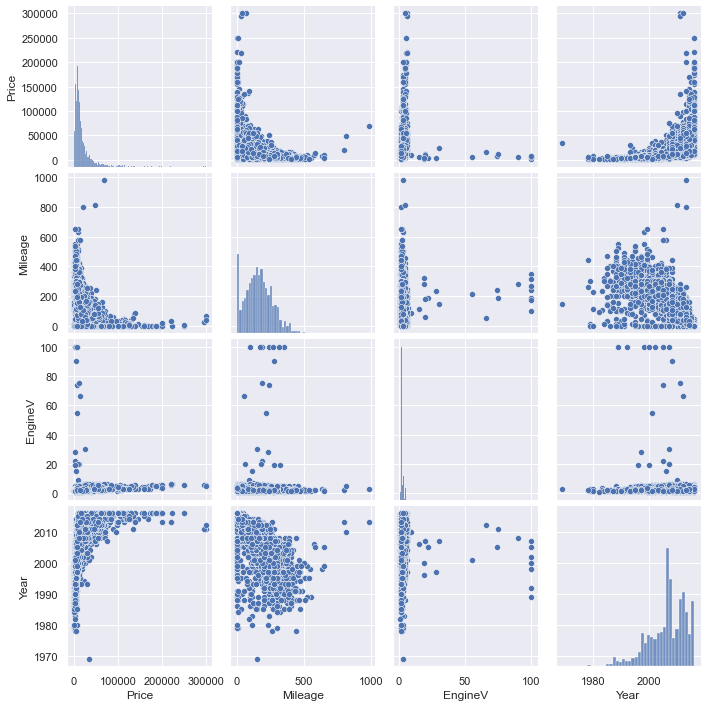

In [11]:
sns.pairplot(data_no_mv)

In [12]:
data_no_mv.describe()

,Price,Mileage,EngineV,Year
count,4025.000000,4025.000000,4025.000000,4025.000000
mean,19552.308065,163.572174,2.764586,2006.379627
std,25815.734988,103.394703,4.935941,6.695595
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.000000,2.200000,2007.000000
75%,21900.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


### Outliers
It looks like there are quite a few outliers in some of the variables. There are some clearly nonsensical values in the EngineV data, as engine volumes are typically never higher than 8l, we can safely remove values above this.

We could remove outliers in the year, price and mileage columns but the values don't appear to be out of the realm of possibility and as such there is little justification for removing what is probably genuine data.

In [13]:
data_no_engine_outliers = data_no_mv[data_no_mv['EngineV']<8]

Price seems to have an exponential tail and an exponential relationship with Mileage and Year so we can take the log transform of price to get more normal distribution in price and linear relationships.

In [14]:
log_price = np.log(data_no_engine_outliers['Price'])

In [15]:
data_log_price = data_no_engine_outliers.copy()
data_log_price['log_Price'] = log_price
data_log_price.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_Price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


In [16]:
data_log_price = data_log_price.drop('Price', axis=1)
data_log_price.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_Price
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


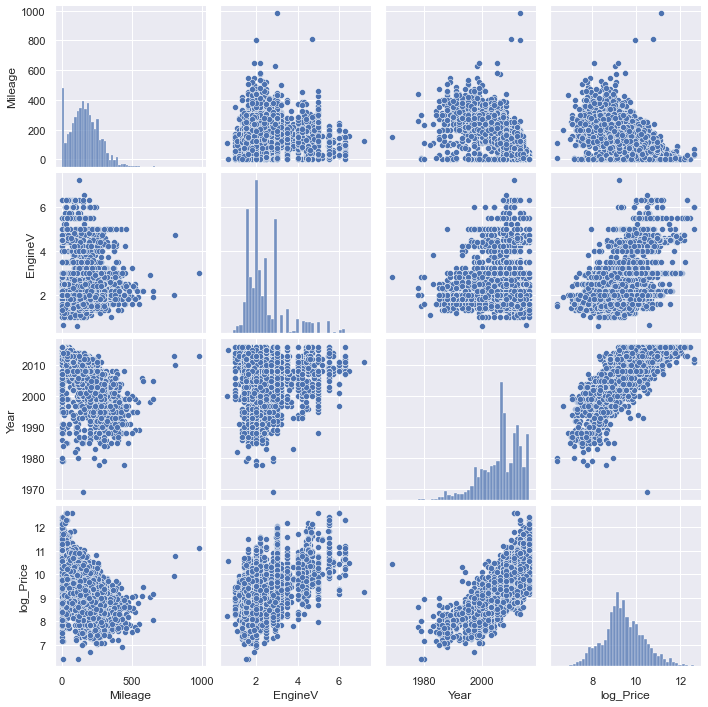

In [17]:
sns.pairplot(data_log_price)

### Define linear regression pipeline

First we label the numeric and categorical features, then define how they will be preprocessed before combining the preprocessing steps with the model in a pipeline. 

In [49]:
#define which columns contain numeric or categorical features
numeric_features = ['Year', 'Mileage', 'EngineV']
categorical_features = ['Body', 'Registration', 'Model', 'Brand', 'Engine Type']

In [50]:
#Normalise numeric features with StandardScaler() and one-hot encode categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [20]:
preprocessor = ColumnTransformer(
        transformers =[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

In [21]:
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

### Model training and results

Split the data into training and test sets (80 and 20% of the data, respectively) then train the model using the training set.

In [51]:
X = data_log_price.drop('log_Price', axis=1)
y = data_log_price['log_Price']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [53]:
reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Mileage',
                                                   'EngineV']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Body', 'Registration',
                                                   'Model', 'Brand',
                                                   'Engine Type'])])),
                ('regressor', LinearRegression())])

In [54]:
reg.score(X_train, y_train)

0.9395661342384287

In [55]:
reg.score(X_test, y_test)

0.9085659094648086

In [56]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(reg, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# convert MAE scores to positive values
scores = abs(scores)

In [57]:
# summarize the model performance
print('MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
print(f'MAE: {np.mean(scores):.3f} ({np.std(scores):.3f})')

MAE: 0.179 (0.009)
MAE: 0.179 (0.009)


In [58]:
y_hat = reg.predict(X_train)

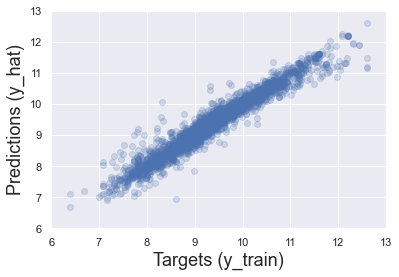

In [59]:
plt.scatter(y_train, y_hat, alpha=0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

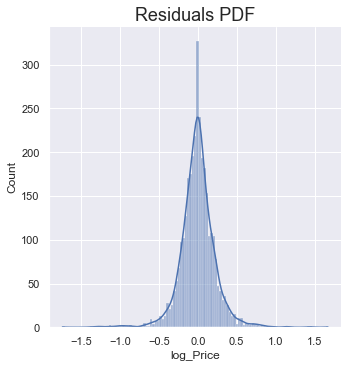

In [63]:
sns.displot(y_train - y_hat, kde=True)
plt.title("Residuals PDF", size=18)

In [65]:
reg_summary = pd.DataFrame(X.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.named_steps['regressor'].coef_
reg_summary

ValueError: Length of values (310) does not match length of index (8)